## Introduction

We are provided data from the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget. We'll conduct a preliminary analysis of the plans based on a relatively small (500) client selection in order to analyze behavior and determine which prepaid plan brings in more revenue. Additionally, we'll conduct hypothesis testing regarding average revenue between users of both plans (one-tail test) as well as comparing the average revenue between two regions (equality of means of two sample populations).

The data has been provided in the following .csv files:

**megaline_users.csv**
- *user_id*: unique user identifier
- *first_name*: user's name
- *last_name*: user's last name
- *age*: user's age in years
- *reg_date*: subscription date (YYYY-MM-DD)
- *churn_date*: the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
- *city*: user's city of residence
- *plan*: calling plan name

**megaline_calls.csv**
- *id*: unique call identifier
- *call_date*: call date (YYYY-MM-DD)
- *duration*: call duration in minutes
- *user_id*: the identifier of the user making the call

**megaline_messages.csv**
- *id*: unique text message identifier
- *message_date*: text message date (YYYY-MM-DD)
- *user_id*: the identifier of the user sending the text

**megaline_internet.csv**
- *id*: unique session identifier
- *mb_used*: the volume of data spent during the session in megabytes
- *session_date*: web session date (YYYY-MM-DD)
- *user_id*: user identifier

**megaline_plans.csv**
- *plan_name*: calling plan name
- *usd_monthly_fee*: monthly charge in US dollars
- *minutes_included*: monthly minute allowance
- *messages_included*: monthly text allowance
- *mb_per_month_included*: data volume allowance in megabytes
- *usd_per_minute*: price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
- *usd_per_message*: price per text after exceeding the package limits
- *usd_per_gb*: price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

## Load data

In [2]:
# When cloning this project, ensure directory/file paths are correct with respect to user's operating system

df_calls = pd.read_csv('datasets/megaline_calls.csv')
df_internet = pd.read_csv('datasets/megaline_internet.csv')
df_messages = pd.read_csv('datasets/megaline_messages.csv')
df_plans = pd.read_csv('datasets/megaline_plans.csv')
df_users = pd.read_csv('datasets/megaline_users.csv')

## Data Preprocessing

### Megaline Plans

In [3]:
df_plans.info()
display(df_plans)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The information above accurately matches the description for the two monthly plans provided by Megaline. The data column is in MB rather than GB, but we can keep the info as is and just add a new column named 'gb_per_month_included' with the appropriate values.

**Enrich Plans Data**

Add column 'gb_per_month_included' with appropriate values.

In [4]:
df_plans['gb_per_month_included'] = [15, 30]
display(df_plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


### Megaline Users

In [5]:
df_users.info()
display(df_users.sample(10, random_state=1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
304,1304,Dominque,Cole,69,"Birmingham-Hoover, AL MSA",2018-10-28,ultimate,NaN
340,1340,Vanna,Stanton,65,"Dallas-Fort Worth-Arlington, TX MSA",2018-07-05,surf,NaN
47,1047,Yuk,French,22,"Indianapolis-Carmel-Anderson, IN MSA",2018-06-16,ultimate,NaN
67,1067,Robt,Allen,37,"Grand Rapids-Kentwood, MI MSA",2018-09-24,surf,2018-11-24
479,1479,Keesha,Burnett,44,"Riverside-San Bernardino-Ontario, CA MSA",2018-11-12,surf,NaN
485,1485,Damion,Woodard,67,"Nashville-Davidson–Murfreesboro–Franklin, TN MSA",2018-08-21,surf,NaN
310,1310,Vincent,Fry,73,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-11-29,surf,NaN
31,1031,Lane,Martin,52,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-07-15,ultimate,NaN
249,1249,Kelly,Goodman,41,"Cincinnati, OH-KY-IN MSA",2018-05-14,ultimate,NaN
90,1090,Brock,Skinner,30,"Indianapolis-Carmel-Anderson, IN MSA",2018-05-12,surf,NaN


The sample from the user dataset is appropriate for the most part, but some columns can be improved. The city is ambiguous in that it has multiple cities and/or states, and each appear to have a value MSA, which is non-descriptive. Additionally, we have NaN values in the 'churn_date' column, which was expected. We can clean up the 'city' column by:
- Using a combination of <code>split()</code> methods with specific delimiters to convert cities and states into lists
- Adding new columns for the list of cities and states, omitting the 'MSA' portion of the string

We can change the 'reg_date' and 'churn_date' data types from object to datetime using <code>to_datetime()</code> and ensure the correct format is specified. This will convert the NaN values in 'churn_date' to NaT, but we want to preserve the datetime object for the valid entries. We will keep the empty values for now.

**Fix User Data**

First, we'll convert 'reg_date' and 'churn_date to datetime objects.

In [6]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

**Enrich User Data**

We can break up the 'reg_date' column into individual components. Additionally, we'll break out the cities and states and assign them to a new column by:
- Splitting the value in 'city' into two strings by the ', ' delimiter. and assigning them to the new columns, 'cities' and 'states' respectively.
- Separate the state(s) from the string 'MSA' with the space delimiter.

In [7]:
df_users['cities'] = df_users['city'].str.split(', ').str[0]
df_users['states'] = df_users['city'].str.split(', ').str[1]

df_users['states'] = df_users['states'].str.split(' ').str[0]

df_users['year'] = df_users['reg_date'].dt.year
df_users['month'] = df_users['reg_date'].dt.month
df_users['day'] = df_users['reg_date'].dt.day

display(df_users.sample(10, random_state=1))
df_users.info()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,cities,states,year,month,day
304,1304,Dominque,Cole,69,"Birmingham-Hoover, AL MSA",2018-10-28,ultimate,NaT,Birmingham-Hoover,AL,2018,10,28
340,1340,Vanna,Stanton,65,"Dallas-Fort Worth-Arlington, TX MSA",2018-07-05,surf,NaT,Dallas-Fort Worth-Arlington,TX,2018,7,5
47,1047,Yuk,French,22,"Indianapolis-Carmel-Anderson, IN MSA",2018-06-16,ultimate,NaT,Indianapolis-Carmel-Anderson,IN,2018,6,16
67,1067,Robt,Allen,37,"Grand Rapids-Kentwood, MI MSA",2018-09-24,surf,2018-11-24,Grand Rapids-Kentwood,MI,2018,9,24
479,1479,Keesha,Burnett,44,"Riverside-San Bernardino-Ontario, CA MSA",2018-11-12,surf,NaT,Riverside-San Bernardino-Ontario,CA,2018,11,12
485,1485,Damion,Woodard,67,"Nashville-Davidson–Murfreesboro–Franklin, TN MSA",2018-08-21,surf,NaT,Nashville-Davidson–Murfreesboro–Franklin,TN,2018,8,21
310,1310,Vincent,Fry,73,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-11-29,surf,NaT,Portland-Vancouver-Hillsboro,OR-WA,2018,11,29
31,1031,Lane,Martin,52,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-07-15,ultimate,NaT,New York-Newark-Jersey City,NY-NJ-PA,2018,7,15
249,1249,Kelly,Goodman,41,"Cincinnati, OH-KY-IN MSA",2018-05-14,ultimate,NaT,Cincinnati,OH-KY-IN,2018,5,14
90,1090,Brock,Skinner,30,"Indianapolis-Carmel-Anderson, IN MSA",2018-05-12,surf,NaT,Indianapolis-Carmel-Anderson,IN,2018,5,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
 8   cities      500 non-null    object        
 9   states      500 non-null    object        
 10  year        500 non-null    int64         
 11  month       500 non-null    int64         
 12  day         500 non-null    int64         
dtypes: datetime64[ns](2), int64(5), object(6)
memory usage: 50.9+ KB


### Megaline Calls

In [8]:
df_calls.info()
display(df_calls.sample(10, random_state=1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
106231,1374_327,1374,2018-12-17,1.17
109017,1385_87,1385,2018-10-20,14.02
76096,1268_600,1268,2018-09-24,12.21
106317,1375_219,1375,2018-12-03,7.03
98706,1354_6,1354,2018-10-16,6.21
50517,1182_90,1182,2018-11-18,1.96
13355,1057_234,1057,2018-10-03,0.00
50255,1181_604,1181,2018-12-28,11.65
129376,1465_773,1465,2018-07-27,12.75
51887,1187_80,1187,2018-12-22,14.22


In [9]:
# Print a sample of data for calls

display(df_calls.sample(10, random_state=1))

,id,user_id,call_date,duration
106231,1374_327,1374,2018-12-17,1.17
109017,1385_87,1385,2018-10-20,14.02
76096,1268_600,1268,2018-09-24,12.21
106317,1375_219,1375,2018-12-03,7.03
98706,1354_6,1354,2018-10-16,6.21
50517,1182_90,1182,2018-11-18,1.96
13355,1057_234,1057,2018-10-03,0.00
50255,1181_604,1181,2018-12-28,11.65
129376,1465_773,1465,2018-07-27,12.75
51887,1187_80,1187,2018-12-22,14.22


There are no missing values. We can adjust the dataset by converting the call date values to a datetime object and add each individual date component as new columns. In accordance with Megaline's billing plan, we can add another column for duration with the values rounded up to the nearest minute.

**Fix Calls Data**

Converting 'call_date' to datetime object.

In [10]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

**Enrich Calls Data**

Adding new columns:
- Individual components of the call date(i.e. 'call_year', 'call_month', etc.)
- Duration rounded up to the nearest minute ('duration_rounded'), type cast as int

In [11]:
df_calls['year'] = df_calls['call_date'].dt.year
df_calls['month'] = df_calls['call_date'].dt.month
df_calls['day'] = df_calls['call_date'].dt.day
df_calls['duration_rounded'] = np.ceil(df_calls['duration']).astype('int')

display(df_calls.sample(10, random_state=1))
df_calls.info()

,id,user_id,call_date,duration,year,month,day,duration_rounded
106231,1374_327,1374,2018-12-17,1.17,2018,12,17,2
109017,1385_87,1385,2018-10-20,14.02,2018,10,20,15
76096,1268_600,1268,2018-09-24,12.21,2018,9,24,13
106317,1375_219,1375,2018-12-03,7.03,2018,12,3,8
98706,1354_6,1354,2018-10-16,6.21,2018,10,16,7
50517,1182_90,1182,2018-11-18,1.96,2018,11,18,2
13355,1057_234,1057,2018-10-03,0.00,2018,10,3,0
50255,1181_604,1181,2018-12-28,11.65,2018,12,28,12
129376,1465_773,1465,2018-07-27,12.75,2018,7,27,13
51887,1187_80,1187,2018-12-22,14.22,2018,12,22,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                137735 non-null  object        
 1   user_id           137735 non-null  int64         
 2   call_date         137735 non-null  datetime64[ns]
 3   duration          137735 non-null  float64       
 4   year              137735 non-null  int64         
 5   month             137735 non-null  int64         
 6   day               137735 non-null  int64         
 7   duration_rounded  137735 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4), object(1)
memory usage: 7.9+ MB


### Megaline Messages

In [12]:
df_messages.info()
display(df_messages.sample(10, random_state=1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
12922,1084_162,1084,2018-11-17
55949,1354_99,1354,2018-10-04
19111,1123_180,1123,2018-11-04
46123,1314_11,1314,2018-12-15
72141,1467_473,1467,2018-05-18
58237,1369_38,1369,2018-12-15
55621,1349_433,1349,2018-10-11
18826,1122_55,1122,2018-07-13
64105,1408_230,1408,2018-06-05
6990,1057_314,1057,2018-11-18


There are no missing entries. We can convert the 'message_date' column to a datetime object, and then add columns with the individual date compontents.

**Fix Messages Data**

Converting the dates to datetime objects.

In [13]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

**Enrich Messages Data**

Adding each date component as individual columns.

In [14]:
df_messages['year'] = df_messages['message_date'].dt.year
df_messages['month'] = df_messages['message_date'].dt.month
df_messages['day'] = df_messages['message_date'].dt.day

display(df_messages.sample(10, random_state=1))
df_messages.info()

,id,user_id,message_date,year,month,day
12922,1084_162,1084,2018-11-17,2018,11,17
55949,1354_99,1354,2018-10-04,2018,10,4
19111,1123_180,1123,2018-11-04,2018,11,4
46123,1314_11,1314,2018-12-15,2018,12,15
72141,1467_473,1467,2018-05-18,2018,5,18
58237,1369_38,1369,2018-12-15,2018,12,15
55621,1349_433,1349,2018-10-11,2018,10,11
18826,1122_55,1122,2018-07-13,2018,7,13
64105,1408_230,1408,2018-06-05,2018,6,5
6990,1057_314,1057,2018-11-18,2018,11,18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   year          76051 non-null  int64         
 4   month         76051 non-null  int64         
 5   day           76051 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 3.5+ MB


### Megaline Internet

In [15]:
df_internet.info()
display(df_internet.sample(10, random_state=1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
13106,1062_76,1062,2018-09-15,225.79
70950,1331_201,1331,2018-09-28,169.69
6195,1035_43,1035,2018-12-27,124.84
2400,1011_140,1011,2018-06-26,0.00
25926,1121_19,1121,2018-12-16,504.92
63187,1291_312,1291,2018-07-08,289.98
16908,1077_28,1077,2018-12-12,465.72
64323,1295_223,1295,2018-12-20,549.30
95470,1445_118,1445,2018-08-13,405.50
55326,1251_137,1251,2018-12-18,285.50


There are no missing values. Since overages for internet use is calculated at the end of the month, we'll leave the column 'mb_used' as is. We can adjust the dataset by converting the dates to a datetime object and add each individual date component as new columns.

**Fix Internet Data**

Converting dates to datetime object.

In [16]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

**Enrich Internet Data**

Adding columns for each individual date component.

In [17]:
df_internet['year'] = df_internet['session_date'].dt.year
df_internet['month'] = df_internet['session_date'].dt.month
df_internet['day'] = df_internet['session_date'].dt.day

display(df_internet.sample(10, random_state=1))
df_internet.info()

,id,user_id,session_date,mb_used,year,month,day
13106,1062_76,1062,2018-09-15,225.79,2018,9,15
70950,1331_201,1331,2018-09-28,169.69,2018,9,28
6195,1035_43,1035,2018-12-27,124.84,2018,12,27
2400,1011_140,1011,2018-06-26,0.00,2018,6,26
25926,1121_19,1121,2018-12-16,504.92,2018,12,16
63187,1291_312,1291,2018-07-08,289.98,2018,7,8
16908,1077_28,1077,2018-12-12,465.72,2018,12,12
64323,1295_223,1295,2018-12-20,549.30,2018,12,20
95470,1445_118,1445,2018-08-13,405.50,2018,8,13
55326,1251_137,1251,2018-12-18,285.50,2018,12,18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   year          104825 non-null  int64         
 5   month         104825 non-null  int64         
 6   day           104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 5.6+ MB


## Overview of Megaline Plans

**Surf**
1. Monthly charge: \$20
2. 500 monthly minutes, 50 texts, and 15 GB of data
3. After exceeding the package limits:
    - 1 minute: \$0.03
    - 1 text message: \$0.03
    - 1 GB of data: \$10

**Ultimate**
1. Monthly charge: \$70
2. 3000 monthly minutes, 1000 text messages, and 30 GB of data
3. After exceeding the package limits:
    - 1 minute: \$0.01
    - 1 text message: \$0.01
    - 1 GB of data: \$7
    
Notes: For calls, each individual call is rounded up to the nearest minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up to the nearest gigabyte.

In [18]:
display(df_plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


## Aggregate Data per User

Since we enriched our data with columns containing the call month, we can break out the calls each user made monthly by grouping the calls dataset by user ID and month, then perform aggregate functions 'count' and 'sum' on the 'id' and 'duration_rounded' columns, respectively. After reseting the index, we'll revert the multi-index column names to a single level with the appropriate names.

In [19]:
# Calculate the number of calls and total minutes made by each user per month

df_total_calls = df_calls.groupby(['user_id','month']).agg({'duration_rounded':('count', 'sum')}).reset_index()
df_total_calls.columns = ['user_id', 'month', 'total_calls', 'total_minutes']

display(df_total_calls)

,user_id,month,total_calls,total_minutes
0,1000,12,16,124
1,1001,8,27,182
2,1001,9,49,315
3,1001,10,65,393
4,1001,11,64,426
...,...,...,...,...
2253,1498,12,39,339
2254,1499,9,41,346
2255,1499,10,53,385
2256,1499,11,45,308


Same methodology from above can be applied here for the total messages sent per customer each month.

In [20]:
# Calculate the number of messages sent by each user per month

df_total_messages = df_messages.groupby(['user_id', 'month'])['id'].count().reset_index(name='total_messages')

display(df_total_messages)

,user_id,month,total_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


Same methodology, groupby 'user_id' and 'month', and use sum() on 'mb_used'. We can further facilitate future calculations by converting the total data usage into GBs by dividing the value by 1024, rounding up using the ceil() method, and storing it into a new column 'total_gb_used'.

In [21]:
# Calculate the volume of internet traffic used by each user per month

df_total_traffic = df_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index(name='total_mb_used')
df_total_traffic['total_gb_used'] = np.ceil(df_total_traffic['total_mb_used']/1024).astype('int')

display(df_total_traffic)

,user_id,month,total_mb_used,total_gb_used
0,1000,12,1901.47,2
1,1001,8,6919.15,7
2,1001,9,13314.82,14
3,1001,10,22330.49,22
4,1001,11,18504.30,19
...,...,...,...,...
2272,1498,12,23137.69,23
2273,1499,9,12984.76,13
2274,1499,10,19492.43,20
2275,1499,11,16813.83,17


We can combine our calculations into a single DataFrame by performing an outer merge on the datasets on both the 'user_id' and 'month' columns.

In [22]:
# Merge the data for calls, minutes, messages, internet based on user_id and month

df_merged = df_total_calls.merge(df_total_messages, on=['user_id', 'month'], how='outer')
df_merged = df_merged.merge(df_total_traffic, on=['user_id','month'], how='outer')

display(df_merged)

,user_id,month,total_calls,total_minutes,total_messages,total_mb_used,total_gb_used
0,1000,12,16.0,124.0,11.0,1901.47,2.0
1,1001,8,27.0,182.0,30.0,6919.15,7.0
2,1001,9,49.0,315.0,44.0,13314.82,14.0
3,1001,10,65.0,393.0,53.0,22330.49,22.0
4,1001,11,64.0,426.0,36.0,18504.30,19.0
...,...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,13039.91,13.0
2289,1361,5,NaN,NaN,2.0,1519.69,2.0
2290,1482,10,NaN,NaN,2.0,NaN,NaN
2291,1108,12,NaN,NaN,NaN,233.17,1.0


We can replace the NaN values inserted during the merge with zeros, and type-change the columns back to integer.

In [23]:
df_merged.replace(np.NaN, 0.0, inplace=True)
df_merged = df_merged.astype({'total_calls':'int',
                             'total_minutes':'int',
                             'total_messages':'int',
                             'total_gb_used':'int'})

df_merged.info()
display(df_merged)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         2293 non-null   int64  
 1   month           2293 non-null   int64  
 2   total_calls     2293 non-null   int32  
 3   total_minutes   2293 non-null   int32  
 4   total_messages  2293 non-null   int32  
 5   total_mb_used   2293 non-null   float64
 6   total_gb_used   2293 non-null   int32  
dtypes: float64(1), int32(4), int64(2)
memory usage: 107.5 KB


,user_id,month,total_calls,total_minutes,total_messages,total_mb_used,total_gb_used
0,1000,12,16,124,11,1901.47,2
1,1001,8,27,182,30,6919.15,7
2,1001,9,49,315,44,13314.82,14
3,1001,10,65,393,53,22330.49,22
4,1001,11,64,426,36,18504.30,19
...,...,...,...,...,...,...,...
2288,1349,12,0,0,61,13039.91,13
2289,1361,5,0,0,2,1519.69,2
2290,1482,10,0,0,2,0.00,0
2291,1108,12,0,0,0,233.17,1


We can add the plan name by:
- Slicing the user dataset to get a DataFrame of user IDs and plans
- Then combine the result with the aggregate dataset above, merging on 'user_id'.

In [24]:
# Add the plan information

df_user_plan = df_users[['user_id', 'plan']]
df_plan_merged = df_merged.merge(df_user_plan, on='user_id')

display(df_plan_merged)

,user_id,month,total_calls,total_minutes,total_messages,total_mb_used,total_gb_used,plan
0,1000,12,16,124,11,1901.47,2,ultimate
1,1001,8,27,182,30,6919.15,7,surf
2,1001,9,49,315,44,13314.82,14,surf
3,1001,10,65,393,53,22330.49,22,surf
4,1001,11,64,426,36,18504.30,19,surf
...,...,...,...,...,...,...,...,...
2288,1204,12,0,0,78,36730.05,36,ultimate
2289,1349,10,0,0,76,13093.55,13,surf
2290,1349,11,0,0,72,17128.26,17,surf
2291,1349,12,0,0,61,13039.91,13,surf


To calculate the monthly revenue, we'll define the function <code>calc_revenue</code>, which takes a DataFrame row as a parameter and returns the total monthly revenue based on a customer's usage as follows:

1. Extracts plan details (limits, overage costs, etc) from the plan dataset via plan name from provided row
2. Takes the difference in customer usage and plan limit and stores the result in a NumPy array
3. Constructs an array of the plan overage costs for each feature
4. Clips the customer usage to calculate overages (negative values indicate there were no overages, thus rounded to 0)
5. Performs NumPy multiplication of the two arrays to calculate individual revenue generated by each feature overage
6. Performs NumPy sum of the result and added to the base plan cost to calculate overall revenue

**Returns**: A floating point number of the caluclated revenue.

The function is applied to each row of the merged DataFrame using the <code>apply()</code> method and specifying the parameter, <code>axis=1</code>. A sample of the merged DataFrame is printed after <code>calc_revenue</code> was applied.

In [25]:
def calc_revenue(row):
    plan_details = df_plans[df_plans['plan_name'] == row['plan']]
    
    revenue = plan_details['usd_monthly_pay']
 
    diff = np.array([row['total_minutes'] - plan_details['minutes_included'],
                     row['total_gb_used'] - plan_details['gb_per_month_included'],
                     row['total_messages'] - plan_details['messages_included']])
    
    plan_limits = np.array([plan_details['usd_per_minute'],
                           plan_details['usd_per_gb'],
                           plan_details['usd_per_message']])

    total_usage = np.clip(diff, a_min=0, a_max=None)
    revenue += np.sum(np.multiply(total_usage, plan_limits))

    return float(revenue)

df_plan_merged['monthly_revenue'] = df_plan_merged.apply(calc_revenue, axis=1)
display(df_plan_merged)

,user_id,month,total_calls,total_minutes,total_messages,total_mb_used,total_gb_used,plan,monthly_revenue
0,1000,12,16,124,11,1901.47,2,ultimate,70.00
1,1001,8,27,182,30,6919.15,7,surf,20.00
2,1001,9,49,315,44,13314.82,14,surf,20.00
3,1001,10,65,393,53,22330.49,22,surf,90.09
4,1001,11,64,426,36,18504.30,19,surf,60.00
...,...,...,...,...,...,...,...,...,...
2288,1204,12,0,0,78,36730.05,36,ultimate,112.00
2289,1349,10,0,0,76,13093.55,13,surf,20.78
2290,1349,11,0,0,72,17128.26,17,surf,40.66
2291,1349,12,0,0,61,13039.91,13,surf,20.33


## Study User Behavior

To calculate useful, descriptive statistics for the aggregated and merged data, we can first visualize the data to reveal an overall picture for monthly user behavior with respect to call, text, and data usage. Data visualization can also quickly reveal outlier datapoints, which we can take into account when addressing various conclusions and hypotheses.

### Calls

We can visualize average monthly call duration for each plan by slicing the merged DataFrame by each plan, Surf and Ultimate. We can then group each slice by month and apply the <code>mean()</code> method to find the monthly average call duration.

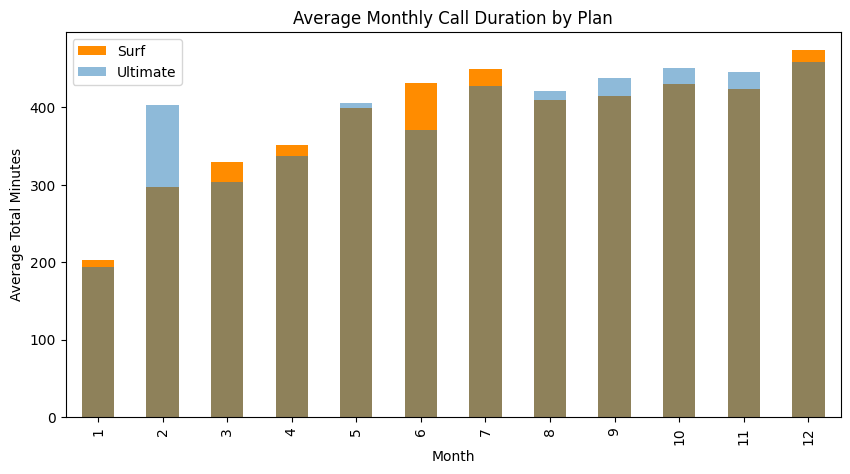

In [26]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plot to visualize it.

surf_calcs = df_plan_merged[df_plan_merged['plan'] == 'surf']
ult_calcs = df_plan_merged[df_plan_merged['plan'] == 'ultimate']

surf_calcs.groupby('month')['total_minutes'].mean().plot(kind='bar',
                                                         figsize=(10, 5),
                                                         color='darkorange')
ult_calcs.groupby('month')['total_minutes'].mean().plot(kind='bar', alpha=0.5)

plt.title('Average Monthly Call Duration by Plan')
plt.xlabel('Month')
plt.ylabel('Average Total Minutes')
plt.legend(['Surf','Ultimate'], loc='upper left')
plt.show()

The following function automates showing certain aggregate functions. Takes a DataFrame, index name, and column name as parameters. Displays the mean, variance, standard deviation, and median of the values in the specified column name, grouped by the index name(s).

In [27]:
def get_stats(df, idx_name, column_name):
    display(df.pivot_table(index=idx_name, values=column_name, aggfunc=['mean', 'var', 'std', 'median']))

Calculating the mean, variance, standard deviation, and median of monthly call duration for both plans.

In [28]:
# Calculate the mean, variance, standard deviation, and median of the monthly call duration

get_stats(df_plan_merged, 'plan', 'total_minutes')

,mean,var,std,median
,total_minutes,total_minutes,total_minutes,total_minutes
plan,,,,
surf,428.749523,54968.279461,234.453150,425
ultimate,430.450000,57844.464812,240.508762,424


Plotting the distribution of average call duration per user by plan.

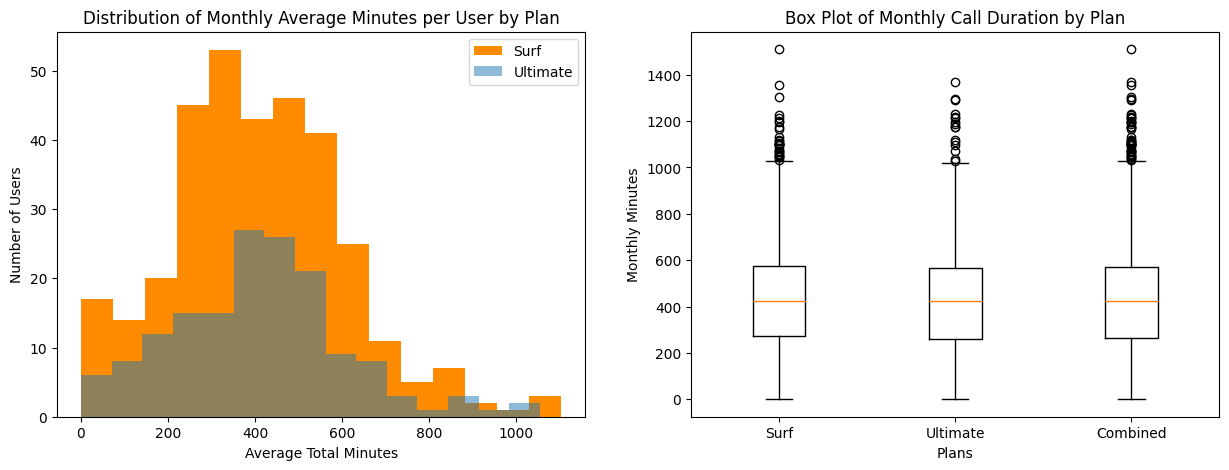

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

surf_calcs.groupby('user_id')['total_minutes'].mean().plot(kind='hist',
                                                            bins=15,
                                                            color='darkorange',
                                                            ax=axes[0])
ult_calcs.groupby('user_id')['total_minutes'].mean().plot(kind='hist',
                                                            bins=15,
                                                            alpha=0.5,
                                                            ax=axes[0])

axes[0].set_title('Distribution of Monthly Average Minutes per User by Plan')
axes[0].set_xlabel('Average Total Minutes')
axes[0].set_ylabel('Number of Users')
axes[0].legend(['Surf','Ultimate'], loc='upper right')

axes[1].boxplot([surf_calcs['total_minutes'], ult_calcs['total_minutes'], df_plan_merged['total_minutes']])
axes[1].set_xticks((1,2,3))
axes[1].set_title('Box Plot of Monthly Call Duration by Plan')
axes[1].set_xticklabels(('Surf', 'Ultimate', 'Combined'))
axes[1].set_xlabel('Plans')
axes[1].set_ylabel('Monthly Minutes')

plt.show()

While Ultimate customers have a higher variance than Surf customers, their average monthly usage is nearly the same.

Aside from the few outlier points, the box plot shows the data is close to a normal distriubtion. From the box and bar plots, both plans reveal customers have very similar monthly call behaviors. Specifically, both set of subscribers have a median duration just above 400 minutes, with 25% and 75% quartile values of about 300 and 600 minutes, respectively. The median value is also close to the average for both plans.

Based on the statistical data, we can see Surf customers generally stay just under their monthly call duration limit of 500 minutes, with most of the overages only exceeding the limit by about 100 minutes (i.e. 75% quartile of approximately 600 minutes). For the Ultimate dataset, all customers stay well within the 3000 minute limit, with only a few customers exceeding 1000 minutes.

We can repeat the statistical analysis for text messages and data to glean more information regarding customer behavior.

### Messages

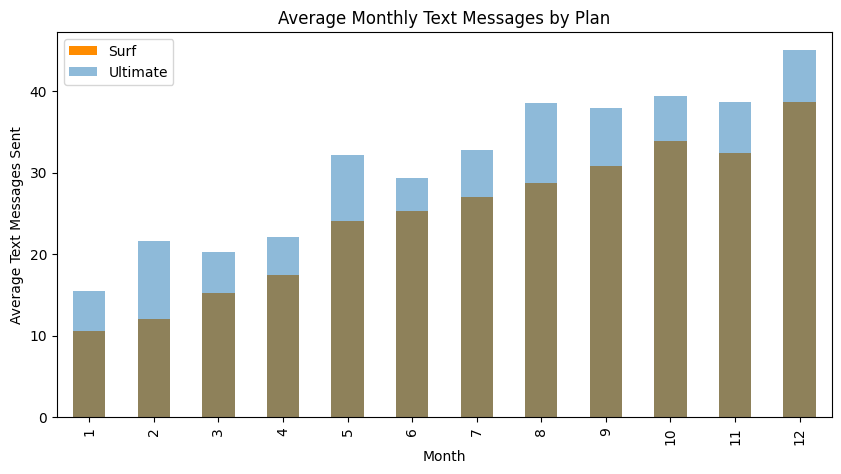

In [30]:
# Compare the average number of messages users of each plan tend to send each month

surf_calcs.groupby('month')['total_messages'].mean().plot(kind='bar',
                                                         figsize=(10, 5),
                                                         color='darkorange')
ult_calcs.groupby('month')['total_messages'].mean().plot(kind='bar', alpha=0.5)

plt.title('Average Monthly Text Messages by Plan')
plt.xlabel('Month')
plt.ylabel('Average Text Messages Sent')
plt.legend(['Surf','Ultimate'], loc='upper left')
plt.show()

Calculating the mean, variance, standard deviation, and median of monthly text messages sent for both plans.

In [31]:
# Calculate the mean, variance, standard deviation, and median of the monthly text messages sent

get_stats(df_plan_merged, 'plan', 'total_messages')

,mean,var,std,median
,total_messages,total_messages,total_messages,total_messages
plan,,,,
surf,31.159568,1126.724522,33.566717,24
ultimate,37.551389,1208.756744,34.767179,30


Plotting the distribution of average monthly texts sent per user by plan.

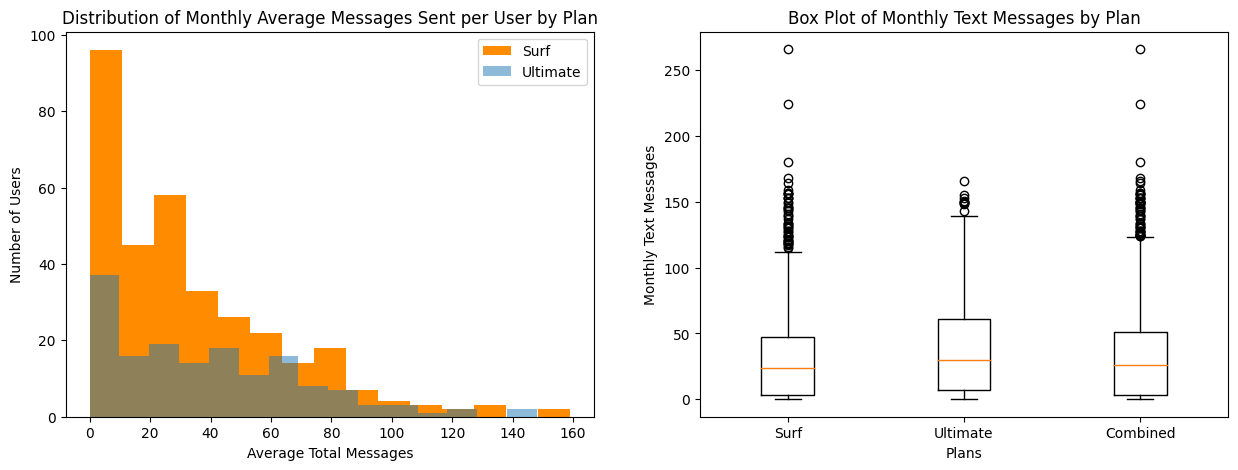

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

surf_calcs.groupby('user_id')['total_messages'].mean().plot(kind='hist',
                                                            bins=15,
                                                            color='darkorange',
                                                            ax=axes[0])
ult_calcs.groupby('user_id')['total_messages'].mean().plot(kind='hist',
                                                            bins=15,
                                                            alpha=0.5,
                                                            ax=axes[0])

axes[0].set_title('Distribution of Monthly Average Messages Sent per User by Plan')
axes[0].set_xlabel('Average Total Messages')
axes[0].set_ylabel('Number of Users')
axes[0].legend(['Surf','Ultimate'], loc='upper right')

axes[1].boxplot([surf_calcs['total_messages'], ult_calcs['total_messages'], df_plan_merged['total_messages']])
axes[1].set_xticks((1,2,3))
axes[1].set_title('Box Plot of Monthly Text Messages by Plan')
axes[1].set_xticklabels(('Surf', 'Ultimate', 'Combined'))
axes[1].set_xlabel('Plans')
axes[1].set_ylabel('Monthly Text Messages')

plt.show()

Both Surf and Ultimate plan customers exhibit similar trend behavior (i.e. positive skew for customer distributions and negative skew for average messages sent by month), but Ultimate plan customers appear to have a slightly higher average volume of text messages sent.

The box plot shows a positive skew for both plans. From the box and bar plots for average monthly text messages sent, both plans reveal customers have similar texting behaviors in that both sets of customers generally text less than the overall average. Furthermore, we can see Surf customers generally stay within their monthly limit of 50 messages. In fact, based on the 75% quartile value, most Surf customers would fall within a limit of just above 50 messages per month. 

Of note, the data set shows all Ultimate customers stay well within their 1000 message limit.

### Internet

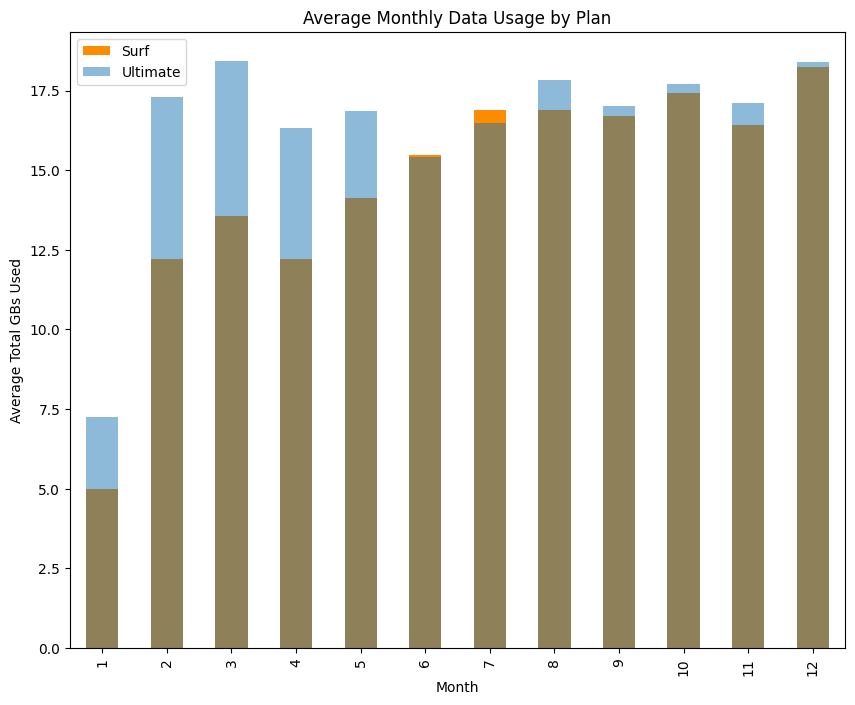

In [33]:
# Compare the average monthly data usage for users of each plan.

surf_calcs.groupby('month')['total_gb_used'].mean().plot(kind='bar', figsize=(10, 8), color='darkorange')
ult_calcs.groupby('month')['total_gb_used'].mean().plot(kind='bar', alpha=0.5)

plt.title('Average Monthly Data Usage by Plan')
plt.xlabel('Month')
plt.ylabel('Average Total GBs Used')
plt.legend(['Surf','Ultimate'], loc='upper left')
plt.show()

Calculating the mean, variance, standard deviation, and median of monthly data usage for both plans.

In [34]:
get_stats(df_plan_merged, 'plan', 'total_gb_used')

,mean,var,std,median
,total_gb_used,total_gb_used,total_gb_used,total_gb_used
plan,,,,
surf,16.670693,61.58360,7.847522,17
ultimate,17.306944,58.83055,7.670108,17


Plotting the distribution of average monthly data usage per user by plan.

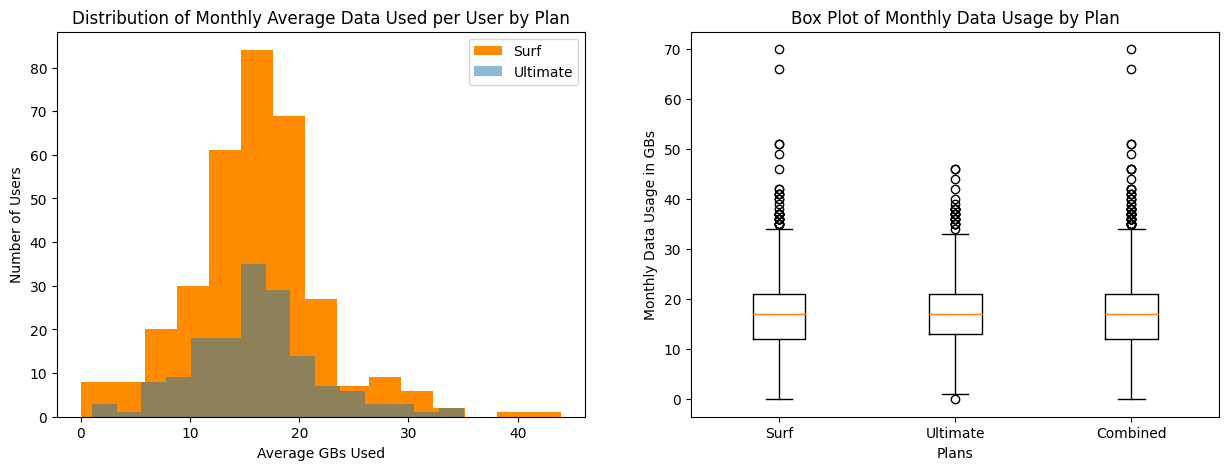

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

surf_calcs.groupby('user_id')['total_gb_used'].mean().plot(kind='hist',
                                                            bins=15,
                                                            color='darkorange',
                                                            ax=axes[0])
ult_calcs.groupby('user_id')['total_gb_used'].mean().plot(kind='hist',
                                                            bins=15,
                                                            alpha=0.5,
                                                            ax=axes[0])

axes[0].set_title('Distribution of Monthly Average Data Used per User by Plan')
axes[0].set_xlabel('Average GBs Used')
axes[0].set_ylabel('Number of Users')
axes[0].legend(['Surf','Ultimate'], loc='upper right')

axes[1].boxplot([surf_calcs['total_gb_used'], ult_calcs['total_gb_used'], df_plan_merged['total_gb_used']])
axes[1].set_xticks((1,2,3))
axes[1].set_title('Box Plot of Monthly Data Usage by Plan')
axes[1].set_xticklabels(('Surf', 'Ultimate', 'Combined'))
axes[1].set_xlabel('Plans')
axes[1].set_ylabel('Monthly Data Usage in GBs')

plt.show()

Both Surf and Ultimate plan customers exhibit slightly different trend behavior. The average monthly data usage for Surf customers shows a slight negative skew, while Ultimate customers (aside from January and March) have a relatively uniform monthly average. Overall, Ultimate customers have higher data consumption by volume, but after May, both sets of customers show similar data consumption volumes. Distributions of users for the average amount of data used is nearly normal, with a few outliers on the high end.

The box plot shows the data is close to a normal distriubtion. Aside from the few aforementioned exceptions, the box and bar plots for both plans reveal customers have very similar data usage behaviors. Specifically, both set of subscribers have a median data consumption close to the monthly average (just above 15 GBs), with 25% and 75% quartile values of about 13 and 21 GBs, respectively.

Based on the statistical data, we can see only about half of Surf customers stayed under their 15 GB limit per month. In fact, about 75% of data use for Surf customers fall within approximately 20 GBs or less. For the Ultimate plan dataset, most customers stay within their 30 GB data limit. Ultimate customers that exceeded the limit generally consumed between 30 and 50 GBs during those months.

### Revenue

Now that we've studied user behavior for both plans, we can analyze the revenue generated from both plans to glean additional insight. In short, if we assume customers stayed within their plan limits, we can calculate the expected revenue that should be generated based off of the monthly base charges. A deviation (e.g. higher than expected revenue generated) would indicate an overage in one of the plan's features.

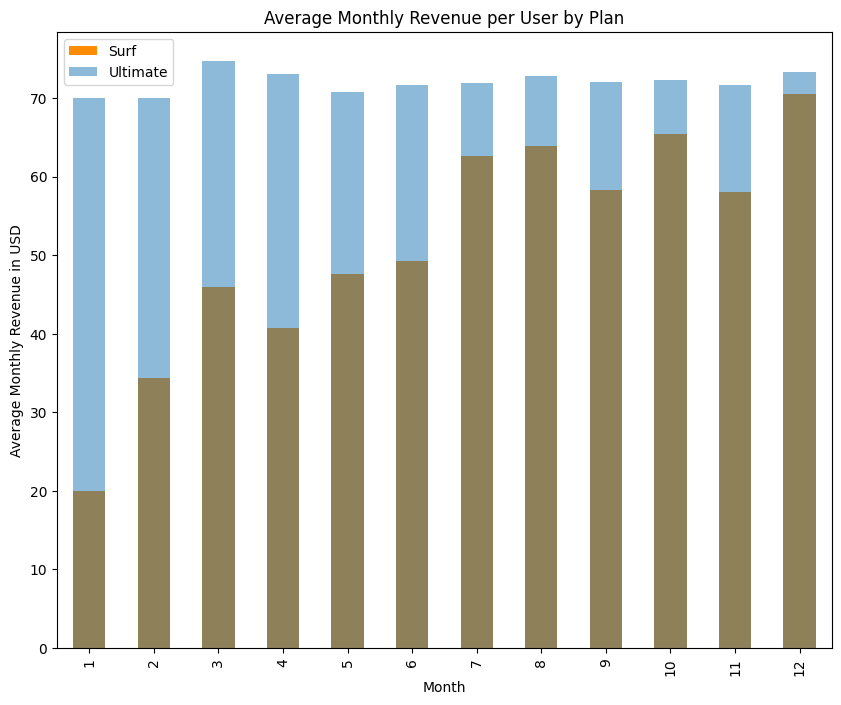

In [36]:
# Compare the average revenue generated by each user each month for both plans.

surf_calcs.groupby('month')['monthly_revenue'].mean().plot(kind='bar', figsize=(10, 8), color='darkorange')
ult_calcs.groupby('month')['monthly_revenue'].mean().plot(kind='bar', alpha=0.5)

plt.title('Average Monthly Revenue per User by Plan')
plt.xlabel('Month')
plt.ylabel('Average Monthly Revenue in USD')
plt.legend(['Surf','Ultimate'], loc='upper left')
plt.show()

Calculating the mean, variance, standard deviation, and median of monthly revenue for both plans.

In [37]:
get_stats(df_plan_merged, 'plan', 'monthly_revenue')

,mean,var,std,median
,monthly_revenue,monthly_revenue,monthly_revenue,monthly_revenue
plan,,,,
surf,60.706408,3067.835152,55.388042,40.36
ultimate,72.313889,129.848486,11.395108,70.00


Plotting the distribution of average monthly revenue per user by plan.

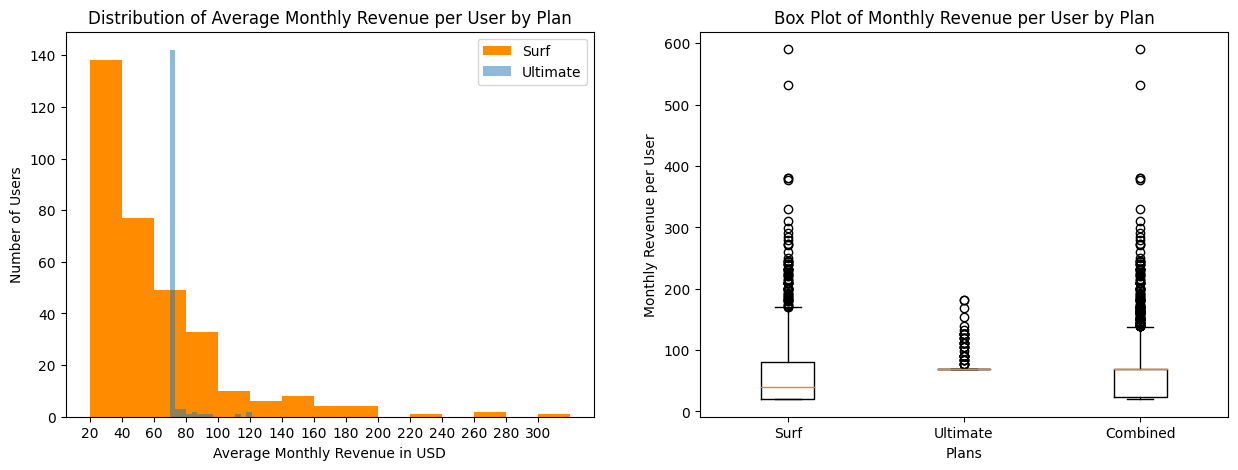

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

surf_calcs.groupby('user_id')['monthly_revenue'].mean().plot(kind='hist',
                                                            bins=15,
                                                            color='darkorange',
                                                            ax=axes[0])
ult_calcs.groupby('user_id')['monthly_revenue'].mean().plot(kind='hist',
                                                            bins=15,
                                                            alpha=0.5,
                                                            ax=axes[0])

axes[0].set_title('Distribution of Average Monthly Revenue per User by Plan')
axes[0].set_xlabel('Average Monthly Revenue in USD')
axes[0].set_ylabel('Number of Users')
axes[0].set_xticks(range(20,320,20))
axes[0].legend(['Surf','Ultimate'], loc='upper right')

axes[1].boxplot([surf_calcs['monthly_revenue'], ult_calcs['monthly_revenue'], df_plan_merged['monthly_revenue']])
axes[1].set_xticks((1,2,3))
axes[1].set_title('Box Plot of Monthly Revenue per User by Plan')
axes[1].set_xticklabels(('Surf', 'Ultimate', 'Combined'))
axes[1].set_xlabel('Plans')
axes[1].set_ylabel('Monthly Revenue per User')

plt.show()

Both distributions exhibit a positive skew, which is expected based on additonal costs for plan overages. Monthly revenue per customer for the Ultimate plan is reasonbly close to the base cost of \$70 per month, with a few instances of overages.

The monthly revenue generated per customer in the Surf plan is highly varied, which suggests many Surf customers exceed their plan limit in at least one of the features. Based on the previous analysis of customer behavior and the customer distribution for monthly revenue, the additional revenue generated from overages are likely from data (Internet) use.

The box plot further confirms our analysis regarding revenue differences for the plans. With a couple of exceptions, the Ultimate plan appears to generate near the expected amount of revenue each month per customer (i.e. customers do not exceed their plan's allotment). This is further supported by the median and average value being close to the base cost of \$70. The Surf plan exhibits a positive skew with the median and mean values being above the base plan cost of \$20.

## Test Statistical Hypotheses

Now that we've analyzed some of the data from both plans and gained insight regarding customer behavior, we can develop and test a couple of stastical hypotheses. The tests will examine whether the average revenues from customers differ between the two plans (or rather how they differ), and whether average revenue from customers differ between certain regions.

$H_0 \text{ 1}$: The average revenue from Surf customers is equal to or greater than the price of the Ultimate plan.  
$H_A \text{ 1}$: The average revenue from Surf customers is less than the price of the Ultimate plan.

Based on the analysis above, we know the revenue generated per month from the Surf plan is highly varied, with the average overall value being significantly higher than the baseline \$20. Since we know there is a wide variety of revenue values in the Surf plan sample, and generally no variety in the Ultimate plan sample, we can perform a one-tailed test in order to aid Megaline's marketing team. Specifically, if we posit that the average revenue for Surf customers is at least 70 USD (equal to or greater than the Ultimate plan's baseline cost), the result of our t-test could suggest to the marketing team to prioritize Surf plan contracts. The alternative hypothesis would be that the average revenue from Surf customers is less than that of the Ultimate plan.

In order to conduct this one-tailed test, we will use the ttest_1samp() method. The sample will be the monthly revenue from Surf plan customers. The sample mean will be compared to a target value equal to the price for the Ulimate plan of \$70. The statistical significance to reject the null hypothesis does not need to be stringent and will remain as the conventional 5%. Of note, since we are conducting a one-tailed test, the p-value will be divided by 2 during the evaluation. 

In [39]:
# Test the hypotheses

sample_1 = surf_calcs['monthly_revenue']
target_mean = 70
alpha = 0.05

results = st.ttest_1samp(sample_1, target_mean)
                             
print('p-value: ', results.pvalue)
print('Sample mean: ', sample_1.mean())

# if the p-value is less than alpha, and sample mean < target_mean, we reject the hypothesis

if (results.pvalue/2 < alpha) and (sample_1.mean() < target_mean):
    print("We reject the null hypothesis: revenue was significantly less than $70")
else:
    print("We can't reject the null hypothesis")

p-value:  3.907643940984577e-11
Sample mean:  60.706408137317226
We reject the null hypothesis: revenue was significantly less than $70


$H_0 \text{ 2}$: The average revenue from customers in the NY-NJ is the same as average revenue from customers in other regions.  
$H_A \text{ 2}$: The average revenue from customers in the NY-NJ differs from the average revenue from customers in other regions.

Rather than looking at plans, we can compare average revenue generated from customers among different regions. We'll specifically explore how the average revenue from customers in the NY-NJ areas compares to the average revenue from customers in other regions. For this test, we will posit that the average revenue will be the same, and alternatively, that the average will be different. A major difference for the samples in this test is that they can contain customers from either plan.

Since we are concerned with the equality of means for two statistical populations, we will use the ttest_ind() method. In order to generate the two samples for our hypothesis, we can separate the users from our datasets by:
- Slicing the user IDs for NY and NJ from the users DataFrame
- Filtering those user IDs from the merged dataset to build the NY-NJ customer base
- Filtering the inverse (i.e. not in) from the merged dataset to build the customers from other regions

The Levene test was used to evaluate both sample's variance equality. The Levene test p-value is less than 1%, thus the equal_var() parameter will be set to False. The statistical significance to reject the null hypothesis does not need to be stringent and will remain as the conventional 5%.

In [40]:
# Test the hypotheses

nynj_users = df_users[(df_users['states'].str.find('NY') != -1) | (df_users['states'].str.find('NJ') != -1)]
df_nynj_calcs = df_plan_merged.query('user_id in @nynj_users.user_id')
df_other_calcs = df_plan_merged.query('user_id not in @nynj_users.user_id')

sample_1 = df_nynj_calcs['monthly_revenue']
sample_2 = df_other_calcs['monthly_revenue']

print('Levene p-value: ', st.levene(sample_1, sample_2).pvalue)
alpha = 0.05
results = st.ttest_ind(sample_1, sample_2, equal_var = False)
                             
print('T-test p-value: ', results.pvalue)

# if the p-value is less than alpha, we reject the hypothesis

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

Levene p-value:  0.0015969343433827885
T-test p-value:  0.10667494170371573
We can't reject the null hypothesis


Although this test does not prove that the average revenue from customers in both regions are the same, the p-value tells us that there is almost a 30% probability that an observation in our test is at least as extreme as our expected value (i.e. average revenue). This is significantly larger than our 5% threshold and indicates that our observation is not so unluckly to have occured by chance, thus we should not reject the null hypothesis.

## Conclusion

Based on the analysis in this project, Megaline's marketing team should focus on advertising the Ultimate plan for revenue generation.

The datasets for 2018 showed customers of both plans had very similar usage behaviors, with Ultimate customers having a slightly larger volume of texts and data usage. Generally, customers stayed within their plan limits, but Surf customers, on average, consistently exceeded their monthly data usage limit. At an extra \$10 per GB in overages, this was likely the reason for the highly varied distribution of average monthly revenue among Surf customers. Conversely, Ultimate customers had minimal overages in 2018, as seen by the revenue distribution bias near the baseline value of 70 USD.

Even though Surf plan customers had more overages, the result of our one-tailed test suggested that the average revenue generated from Surf plan customers was significantly less than the average/baseline price for the Ultimate plan. 

The result of the second t-test showed strong evidence that the average revenue generated from different regions are the same (specifically compared NY-NJ versus everywhere else). It is important to note that this does not necessarily make an implication between Surf and Ultimate plan revenue differences, but rather could suggest customer usage behavior doesn't necessarily change by region. In the scope of this project, the test result could show Megaline that advertisments do not have to be regionalized. Until more testing and analysis is conducted, it cannot be asserted whether or not the result of this test is remarkable enough to help marketing decisions.